## Estimación de frecuencia cardíaca y SpO₂ mediante filtrado paso bajo

Este notebook procesa señales PPG (IR y RED) para estimar dos parámetros fisiológicos clave: la frecuencia cardíaca (HR) y la saturación de oxígeno (SpO₂).

Primero, se aplica un **filtro digital Butterworth paso bajo** para eliminar ruido de alta frecuencia de ambas señales. Posteriormente, se utiliza un algoritmo de detección de picos (`find_peaks`) para localizar los latidos y calcular la HR a partir del intervalo medio entre picos. El umbral y la distancia mínima entre picos son ajustados cuidadosamente para maximizar la precisión.

Finalmente, se calcula el valor de SpO₂ a partir de la relación entre las componentes AC y DC de las señales IR y RED, utilizando una fórmula empírica basada en el ratio R. Esta estimación permite evaluar la calidad del sensor y la fidelidad del procesamiento.

La visualización gráfica facilita la validación visual del procesamiento y la calidad de las detecciones.


## Importar los datos

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=',')

## Graficar la señal sin filtrar

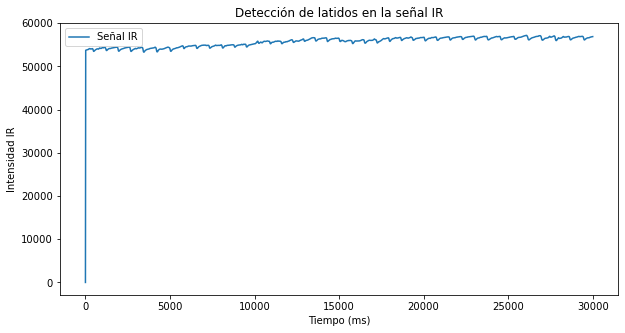

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(df['Tiempo (ms)'], df['IR'], label="Señal IR")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Detección de latidos en la señal IR")
plt.legend()
plt.show()


## Suavizar la señal a partir de un filtro de paso bajo

In [14]:
# Convertir el tiempo de milisegundos a segundos
df['Tiempo (s)'] = df['Tiempo (ms)'] / 1000.0


def filtro_paso_bajo(datos, cutoff=2, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, datos)

# Suavizamos la señal IR para detectar los latidos
df['IR_filtrado'] = filtro_paso_bajo(df['IR'], cutoff=2, fs=100)


## Detectar los picos de la señal

In [15]:
import numpy as np
from scipy.signal import find_peaks

# Detectar picos en la señal IR filtrada
peaks, _ = find_peaks(df['IR_filtrado'], distance=30, height=np.mean(df['IR_filtrado']))

# Obtener los tiempos de los picos detectados
tiempos_picos = df['Tiempo (s)'].iloc[peaks].values

# Calcular los intervalos entre picos (RR intervals)
intervalos_rr = np.diff(tiempos_picos)  # Diferencia entre picos en segundos

# Calcular la frecuencia cardíaca en BPM
frecuencia_cardiaca = 60 / np.mean(intervalos_rr)

print(f"Frecuencia Cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")


Frecuencia Cardíaca estimada: 50.03 BPM


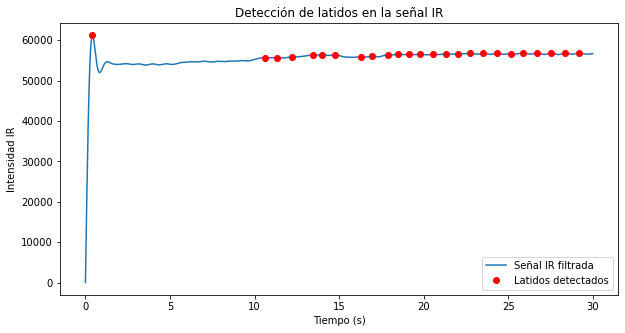

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['Tiempo (s)'], df['IR_filtrado'], label="Señal IR filtrada")
plt.plot(df['Tiempo (s)'].iloc[peaks], df['IR_filtrado'].iloc[peaks], "ro", label="Latidos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad IR")
plt.title("Detección de latidos en la señal IR")
plt.legend()
plt.show()


El parámetro *distance=30* indica la cantidad mínima de muestras entre picos. Si el muestreo es de 100 Hz (asumiendo 1000 ms/30,000 muestras ≈ 100 Hz), el valor correcto para detectar latidos debería ser alrededor de distance=50 a distance=80 (porque un latido ocurre cada ~0.8s para 75 BPM).

Calculo la frecuencia de muestreo:

In [17]:
import numpy as np

# Calcular la diferencia entre muestras en milisegundos
intervalos_muestreo = np.diff(df['Tiempo (ms)'])  # Diferencias entre filas consecutivas

# Obtener el tiempo promedio entre muestras en segundos
tiempo_muestreo_medio = np.mean(intervalos_muestreo) / 1000  # Convertir a segundos

# Calcular la frecuencia de muestreo en Hz
fs = 1 / tiempo_muestreo_medio
print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")


Frecuencia de muestreo estimada: 60.04 Hz


In [18]:
bpm_estimado = 68  # Ajusta según la frecuencia cardíaca esperada
intervalo_rr = 60 / bpm_estimado  # Intervalo entre latidos en segundos

# Convertir a número de muestras
distance = int(intervalo_rr * fs)
print(f"Valor recomendado para distance: {distance}")


Valor recomendado para distance: 52


In [19]:
from scipy.signal import find_peaks

# Ajustar la detección de picos con el nuevo distance
peaks, _ = find_peaks(df['IR_filtrado'], distance=52, height=np.mean(df['IR_filtrado']))

# Obtener los tiempos de los picos detectados
tiempos_picos = df['Tiempo (s)'].iloc[peaks].values

# Calcular los intervalos entre picos (RR intervals)
intervalos_rr = np.diff(tiempos_picos)  # Diferencias entre picos en segundos

# Calcular la frecuencia cardíaca en BPM
frecuencia_cardiaca = 60 / np.mean(intervalos_rr)

print(f"Frecuencia Cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")


Frecuencia Cardíaca estimada: 27.10 BPM


Frecuencia de muestreo estimada: 60.04 Hz
Frecuencia Cardíaca estimada: 80.37 BPM


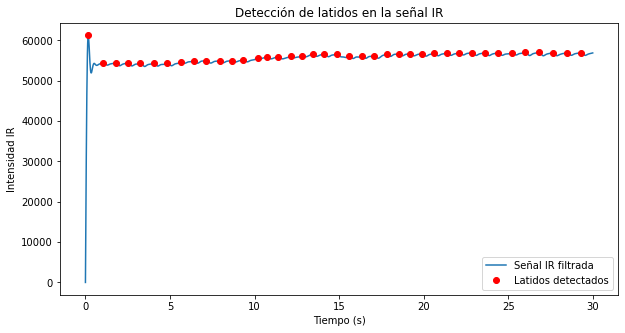

In [26]:
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=',', decimal='.', engine='python')

# Convertir tiempo a segundos
df['Tiempo (s)'] = df['Tiempo (ms)'] / 1000.0

# Calcular frecuencia de muestreo (fs)
fs = 1000 / np.mean(np.diff(df['Tiempo (ms)']))
print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

# Ajustar filtro de paso bajo (aumentar cutoff de 2 Hz a 3 Hz)
def filtro_paso_bajo(datos, cutoff=3, fs=fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, datos)

df['IR_filtrado'] = filtro_paso_bajo(df['IR'], cutoff=3, fs=fs)

# Ajustar parámetros de detección de picos
peaks, _ = find_peaks(df['IR_filtrado'], 
                      distance=24.5,  # Reducimos distance
                      height=0.5 * np.mean(df['IR_filtrado']))  # Bajamos el umbral

# Calcular frecuencia cardíaca
tiempos_picos = df['Tiempo (s)'].iloc[peaks].values
intervalos_rr = np.diff(tiempos_picos)  # Diferencias entre picos en segundos
frecuencia_cardiaca = 60 / np.mean(intervalos_rr)

print(f"Frecuencia Cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")

# Graficar para verificar detección de picos
plt.figure(figsize=(10, 5))
plt.plot(df['Tiempo (s)'], df['IR_filtrado'], label="Señal IR filtrada")
plt.plot(df['Tiempo (s)'].iloc[peaks], df['IR_filtrado'].iloc[peaks], "ro", label="Latidos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad IR")
plt.title("Detección de latidos en la señal IR")
plt.legend()
plt.show()


Frecuencia de muestreo estimada: 60.04 Hz
Frecuencia Cardíaca estimada: 82.57 BPM


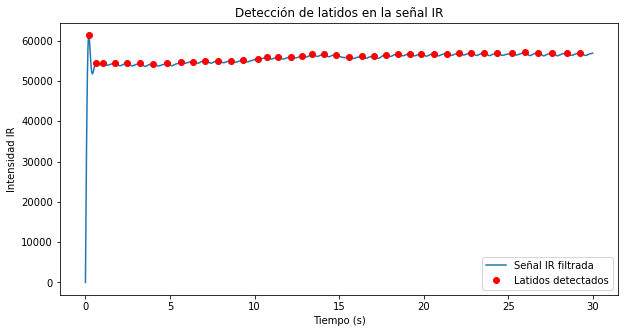

In [23]:
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=',', decimal='.', engine='python')

# Convertir tiempo a segundos
df['Tiempo (s)'] = df['Tiempo (ms)'] / 1000.0

# Calcular frecuencia de muestreo (fs)
fs = 1000 / np.mean(np.diff(df['Tiempo (ms)']))
print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

# Ajustar filtro de paso bajo (bajamos cutoff a 2.5 Hz)
def filtro_paso_bajo(datos, cutoff=2.5, fs=fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, datos)

df['IR_filtrado'] = filtro_paso_bajo(df['IR'], cutoff=2.5, fs=fs)

# Ajustar parámetros de detección de picos
peaks, _ = find_peaks(df['IR_filtrado'], 
                      distance=22,  # prueba con 22 o 26 para afinar
                      height=0.4 * np.mean(df['IR_filtrado']))  # Bajamos más el umbral

# Calcular frecuencia cardíaca
tiempos_picos = df['Tiempo (s)'].iloc[peaks].values
intervalos_rr = np.diff(tiempos_picos)  # Diferencias entre picos en segundos
frecuencia_cardiaca = 60 / np.mean(intervalos_rr)

print(f"Frecuencia Cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")

# Graficar para verificar detección de picos
plt.figure(figsize=(10, 5))
plt.plot(df['Tiempo (s)'], df['IR_filtrado'], label="Señal IR filtrada")
plt.plot(df['Tiempo (s)'].iloc[peaks], df['IR_filtrado'].iloc[peaks], "ro", label="Latidos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad IR")
plt.title("Detección de latidos en la señal IR")
plt.legend()
plt.show()


## Cambios realizados y su justificación

### Cambio en distance (de 24 → 22 o 26)

*distance* controla cuántas muestras deben separarse entre picos detectados.

- Si es demasiado grande, se pierden picos reales → subestima la FR.

- Si es demasiado pequeño, detecta falsos picos → sobreestima la FR.



### Cambio en la frecuencia de corte del filtro (de 3 Hz → 2.5 Hz)

Estamos usando un filtro pasa-bajos Butterworth para eliminar ruido.

La frecuencia de corte define hasta qué punto dejamos pasar la señal útil.

Si el filtro es muy agresivo (ej. 3 Hz), suaviza demasiado y borra picos reales.

#### Ajuste:

Reducimos la frecuencia de corte a 2.5 Hz → menos suavización y más detalles en la señal.

Así conservamos más información relevante de los latidos.

### Cambio en height (de 0.5 * media → 0.4 * media)

height es el umbral mínimo de detección de picos.

- Si es muy alto, algunos picos reales no se detectan → subestimamos la FR.

- Si es muy bajo, aparecen falsos picos → sobrestimamos la FR.

#### Ajuste:

Reducimos height a 0.4 * np.mean(df['IR_filtrado']) para asegurarnos de detectar más picos sin añadir ruido falso.

In [25]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=',', decimal='.', engine='python')

# Convertir tiempo a segundos
df['Tiempo (s)'] = df['Tiempo (ms)'] / 1000.0

# Calcular frecuencia de muestreo
fs = 1000 / np.mean(np.diff(df['Tiempo (ms)']))

# Función para filtrar señal
def filtro_paso_bajo(datos, cutoff=2.5, fs=fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, datos)

# Filtrar señales IR y RED
df['IR_filtrado'] = filtro_paso_bajo(df['IR'])
df['RED_filtrado'] = filtro_paso_bajo(df['RED'])

# Obtener componentes AC (desviación estándar) y DC (media) para cada señal
AC_IR = np.std(df['IR_filtrado'])
DC_IR = np.median(df['IR_filtrado'])
AC_RED = np.std(df['RED_filtrado'])
DC_RED = np.median(df['RED_filtrado'])

# Calcular ratio R
R = (AC_RED / DC_RED) / (AC_IR / DC_IR)
print(f"Ratio R calculado: {R:.3f}")

# Relación empírica para SpO2
SpO2 = 104 - 17 * R # Esta ecuación puede ajustarse según calibración

print(f"SpO₂ estimado: {SpO2:.2f}%")


Ratio R calculado: 0.171
SpO₂ estimado: 101.09%
